In [1]:
import numpy as np
import random
from utils import *
from train import train_2l,train_1,train_3l
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
def get_training_adj_lists(labels, adj_lists,seed):
    np.random.seed(seed)
    random.seed(seed)
    num_nodes = labels.shape[0]
    rand_indices = np.random.permutation(num_nodes)
    train = rand_indices[:int(num_nodes*0.6)]
    valid = rand_indices[int(num_nodes*0.6):int(num_nodes*0.8)]
    test = (rand_indices[int(num_nodes*0.8):])    
    train_and_valid = rand_indices[:int(num_nodes*0.8)]
    
    adj_lists_train = defaultdict(set)
    adj_lists_valid = defaultdict(set)
    for key in adj_lists:
        if key in train:
            nodes = []
            for node in adj_lists[key]:
                if node in train:
                    nodes.append(node)
            nodes = set(nodes)
            adj_lists_train[key] = nodes
    for key in adj_lists:
        if key in train_and_valid:
            nodes = []
            for node in adj_lists[key]:
                if node in train_and_valid:
                    nodes.append(node)
            nodes = set(nodes)
            adj_lists_valid[key] = nodes
    return adj_lists_train,adj_lists_valid,train,valid,test

In [3]:
def shuffle_edges(dict_edges,n_swap,n_try):
    G_ = nx.Graph(dict_edges)
    num_edges = nx.number_of_edges(G_)
    print(num_edges)
    print(num_edges*n_swap)
    G_swap = nx.double_edge_swap(G_,int(n_swap*num_edges),n_try*int(n_swap*num_edges))
    edge_list = list(nx.to_edgelist(G_swap))
    adj_lists = defaultdict(set)
    for i in range(len(edge_list)):
        adj_lists[edge_list[i][0]].add(edge_list[i][1])
        adj_lists[edge_list[i][1]].add(edge_list[i][0])    
    return adj_lists

In [4]:
feat_data,labels,full_adjs = load_data('cora',path='/home/zhihao/Document/gnn_fd/graphSage/data/')

In [ ]:
full_adjs_shuffle = shuffle_edges(full_adjs,1000,11000000000)

In [113]:

results_mlp = []
    
for seed in range(10):
    import torch
    from torch import nn
    from torch.nn import ReLU
    
    from torch.autograd import Variable
    from sklearn.metrics import f1_score,accuracy_score
    import glob
    import os
    import time
    batch_size = 128
    t_total = time.time()
    loss_values = []
    loss_train = []
    bad_counter = 0
    epochs = 70
    best = epochs + 1
    best_epoch = 0   
    temp_path = './cora/'
    patience = 5
    num_class = 7
    hidden_num = 128
    lr = 0.0002
    #results = []
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,seed)
    class MLPModel(nn.Module):
        def __init__(self,num_classes,hidden_dim,feature_dim):
            super(MLPModel,self).__init__()
            self.hidden = nn.Linear(feature_dim,hidden_dim)
            self.layer = nn.Linear(hidden_dim,num_classes)
            self.xent = nn.CrossEntropyLoss()
            self.act1 = ReLU()
        def forward(self,nodes):
            X = self.hidden(nodes)
            X = self.act1(X)
            scores = self.layer(X)
            return scores
        def loss(self,nodes,labels):
            scores = self.forward(nodes)
            return self.xent(scores,labels.squeeze())
        
    mlp = MLPModel(num_class,hidden_num,feat_data.shape[1] )
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, mlp.parameters()), lr=lr)
    
    
    for epoch in range(epochs):
        random.shuffle(training)
        num_batches = int(len(training) / batch_size) + 1
        train_losses = []
        start_time = time.time()
        for batch in range(num_batches):   
            i_start = batch * batch_size
            i_end = min((batch + 1) * batch_size, len(training))
            batch_nodes = training[i_start:i_end]
            
            optimizer.zero_grad()
            loss = mlp.loss(Variable(torch.Tensor(feat_data[np.array(batch_nodes)])),Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
            
            train_losses.append(loss.data.item())
            loss.backward()
            optimizer.step()
    
        
        num_batches_valid = int(len(validation) / batch_size) 
        valid_losses = []
        for batch in range(num_batches_valid):
            i_start = batch * batch_size
            i_end = min((batch + 1) * batch_size, len(validation))
            batch_nodes = validation[i_start:i_end]
    
            loss = mlp.loss(Variable(torch.Tensor(feat_data[np.array(batch_nodes)])),Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
            
            valid_losses.append(loss.data.item())
  
        
        loss_train.append(np.average(train_losses))
        loss_values.append(np.average(valid_losses))
        torch.save(mlp.state_dict(),temp_path+'{}.pkl'.format(epoch))
        if loss_values[-1] < best:
            best = loss_values[-1]
            best_epoch = epoch 
            bad_counter = 0
        else:
            bad_counter += 1
        if bad_counter == patience:
            break
        files = glob.glob(temp_path+'*.pkl')
        for file in files:
            epoch_nb = int(file[len(temp_path):].split('.')[0])
            if epoch_nb < best_epoch:
                os.remove(file)
    files = glob.glob(temp_path+'*.pkl')
    for file in files:
        epoch_nb = int(file[len(temp_path):].split('.')[0])
        if epoch_nb > best_epoch:
            os.remove(file)

    mlp.load_state_dict(torch.load(temp_path+'{}.pkl'.format(best_epoch)))        
    print(best_epoch)
    
    num_batches_test = int(len(testing) / batch_size) 
    test_outputs = []
    test_labels = []
    for batch in range(num_batches_test):
        i_start = batch * batch_size
        i_end = (batch + 1) * batch_size
        batch_nodes = testing[i_start:i_end]
        test_output = torch.zeros(batch_size,num_class)
        for i in range(3):
            test_output = test_output + mlp.forward(torch.Tensor(feat_data[np.array(batch_nodes)]))
        test_outputs.extend(list(test_output.data.cpu().numpy().argmax(axis=1)))
        test_labels.extend(list(labels[batch_nodes]))
        
    results_mlp.append([loss_train,loss_values,accuracy_score(test_labels,test_outputs)])

65
61
65
65
55
65
63
55
64
60


In [115]:
result_mlp = []
for i in range(10):
    result_mlp.append(results_mlp[i][2])

In [7]:
ratio_list = [x*0.05 for x in range(13)]
results_0 = []
num = 10
for ratio in ratio_list:
    full_adjs_shuffle = shuffle_edges(full_adjs,ratio,10)
    results_sagegcn_0 = []
    for seed in range(num):
        training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs_shuffle,seed)
        
        new_adjs = {}
        for key in full_adjs_shuffle:
            neighbs_set = full_adjs_shuffle[key] | set([key])
            n_list = []
            for node in neighbs_set:
                n_list.extend(full_adjs_shuffle[node] & neighbs_set)
            new_adjs[key] = set()
            
            neighbs_set.remove(key)
            for node in neighbs_set:
                new_adjs[key].add((node,n_list.count(node)))
        new_training_adjs = {}
        for key in training_adjs:
            neighbs_set = training_adjs[key] | set([key])
            n_list = []
            for node in neighbs_set:
                n_list.extend(training_adjs[node] & neighbs_set)
            new_training_adjs[key] = set()
            
            neighbs_set.remove(key)
            for node in neighbs_set:
                new_training_adjs[key].add((node,n_list.count(node)))
        
        results_sagegcn_0.append(train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,1000,2000,0,100,5,7,'./cora/',hidden=128,lr=0.0002,batch_size=128))
    result_0 = []
    for i in range(num):
        result_0.append(results_sagegcn_0[i][2])
    results_0.append(result_0)



5278
0.0
5278
263.90000000000003
5278
527.8000000000001
5278
791.7000000000002
5278
1055.6000000000001
5278
1319.5
5278
1583.4000000000003
5278
1847.3000000000002
5278
2111.2000000000003
5278
2375.1
5278
2639.0
5278
2902.9
5278
3166.8000000000006


In [39]:
ratio_list = [x*0.05 for x in range(11)]
results_0_cancat = []
num = 10
for ratio in ratio_list:
    full_adjs_shuffle = shuffle_edges(full_adjs,ratio,10)
    results_sagegcn_0 = []
    for seed in range(num):
        training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs_shuffle,seed)
        
        new_adjs = {}
        for key in full_adjs_shuffle:
            neighbs_set = full_adjs_shuffle[key] | set([key])
            n_list = []
            for node in neighbs_set:
                n_list.extend(full_adjs_shuffle[node] & neighbs_set)
            new_adjs[key] = set()
            
            neighbs_set.remove(key)
            for node in neighbs_set:
                new_adjs[key].add((node,n_list.count(node)))
        new_training_adjs = {}
        for key in training_adjs:
            neighbs_set = training_adjs[key] | set([key])
            n_list = []
            for node in neighbs_set:
                n_list.extend(training_adjs[node] & neighbs_set)
            new_training_adjs[key] = set()
            
            neighbs_set.remove(key)
            for node in neighbs_set:
                new_training_adjs[key].add((node,n_list.count(node)))
        
        results_sagegcn_0.append(train_1(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0,100,5,7,'./cora/',hidden=128,lr=0.0002,batch_size=128))
    result_0 = []
    for i in range(num):
        result_0.append(results_sagegcn_0[i][2])
    results_0_cancat.append(result_0)



5278
0.0
5278
263.90000000000003
5278
527.8000000000001
5278
791.7000000000002
5278
1055.6000000000001
5278
1319.5
5278
1583.4000000000003
5278
1847.3000000000002
5278
2111.2000000000003
5278
2375.1
5278
2639.0


In [40]:
a = []
for i in results_0_cancat:
    a.append(i[2])
a

[0.83984375,
 0.822265625,
 0.8125,
 0.787109375,
 0.7734375,
 0.763671875,
 0.765625,
 0.751953125,
 0.751953125,
 0.767578125,
 0.751953125]

In [42]:
a = []
for i in results_best:
    a.append(i[2])
a

[0.853515625,
 0.833984375,
 0.83984375,
 0.81640625,
 0.7890625,
 0.7890625,
 0.771484375,
 0.77734375,
 0.76953125,
 0.76171875,
 0.759765625]

In [41]:
a = []
for i in results_0:
    a.append(i[2])
a

[0.853515625,
 0.8046875,
 0.798828125,
 0.751953125,
 0.7578125,
 0.7265625,
 0.67578125,
 0.66015625,
 0.62890625,
 0.623046875,
 0.642578125]

In [216]:
results_sagegcn_075 = []
for seed in range(10):
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs_shuffle,seed)
    
    new_adjs = {}
    for key in full_adjs_shuffle:
        neighbs_set = full_adjs_shuffle[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs_shuffle[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))

    new_valid_adjs = {}
    for key in valid_adjs:
        neighbs_set = valid_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(valid_adjs[node] & neighbs_set)
        new_valid_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_valid_adjs[key].add((node,n_list.count(node)))            
            
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
            
            
    
    
    results_sagegcn_075.append(train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,1.3,100,5,7,'./cora/',hidden=128,lr=0.0002,batch_size=128)
)



In [ ]:
ratio_list = [x*0.05 for x in range(13)]
results_best = []
results_best_r = []
num = 10 
for ratio in ratio_list:
    full_adjs_shuffle = shuffle_edges(full_adjs,ratio,10)
    results_sagegcn_best = []
    results_sagegcn_best_r = []
    for seed in range(num):
        training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs_shuffle,seed)
        
        new_adjs = {}
        for key in full_adjs_shuffle:
            neighbs_set = full_adjs_shuffle[key] | set([key])
            n_list = []
            for node in neighbs_set:
                n_list.extend(full_adjs_shuffle[node] & neighbs_set)
            new_adjs[key] = set()
            
            neighbs_set.remove(key)
            for node in neighbs_set:
                new_adjs[key].add((node,n_list.count(node)))
        new_training_adjs = {}
        for key in training_adjs:
            neighbs_set = training_adjs[key] | set([key])
            n_list = []
            for node in neighbs_set:
                n_list.extend(training_adjs[node] & neighbs_set)
            new_training_adjs[key] = set()
            
            neighbs_set.remove(key)
            for node in neighbs_set:
                new_training_adjs[key].add((node,n_list.count(node)))
        res = train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,1000,2000,0,100,5,7,'./cora/',hidden=128,lr=0.0002,batch_size=128)   
        r = 0
        for i in range(1,11):
            temp = train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,1000,2000,0.2*i,100,5,7,'./cora/',hidden=128,lr=0.0002,batch_size=128)
            if res[2] < temp[2]:
                res = temp
                r = i * 0.2
        results_sagegcn_best.append(res)
        results_sagegcn_best_r.append(r)
    
    result_best = []
    for i in range(num):
        result_best.append(results_sagegcn_best[i][2])
    results_best.append(result_best)
    results_best_r.append(results_sagegcn_best_r)
    


5278
0.0


In [8]:
import pickle
def save_list(path,list_):
    file = open(path,'wb')
    pickle.dump(list_,file)
    file.close()

In [32]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/cora/mlp.pkl',results_mlp)

In [9]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/cora/sage_0_randomedge.pkl',results_0)

In [ ]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/cora/sage_best_randomedge1.pkl',results_best)

In [ ]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/cora/sage_best_randomedge_r.pkl',results_best_r)

In [ ]:
results_best_r

In [2]:
results_best

NameError: name 'results_best' is not defined

In [1]:
results_0

NameError: name 'results_0' is not defined

In [37]:
for i in range(len(results_0)):
    print(sum(results_0[i])/10)

0.8685546875
0.8359375
0.823046875
0.7931640625
0.7689453125
0.7359375
0.7078125
0.671484375
0.6564453125
0.6380859375
0.62265625


In [38]:
for i in range(len(results_best)):
    print(sum(results_best[i])/10)

0.8818359375
0.86328125
0.84921875
0.8373046875
0.81640625
0.8072265625
0.7998046875
0.798046875
0.78984375
0.7833984375
0.7787109375


In [38]:
training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,0)

In [47]:
batch_size = 128
t_total = time.time()
loss_values = []
loss_train = []
bad_counter = 0
epochs = 100
best = epochs + 1
best_epoch = 0   
temp_path = './cora/'
patience = 100
num_class = 7
hidden_num = 128
lr = 0.0002

mlp = MLPModel(num_class,hidden_num,feat_data.shape[1] )
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, mlp.parameters()), lr=lr)


for epoch in range(epochs):
    random.shuffle(training)
    num_batches = int(len(training) / batch_size) + 1
    train_losses = []
    start_time = time.time()
    for batch in range(num_batches):   
        i_start = batch * batch_size
        i_end = min((batch + 1) * batch_size, len(training))
        batch_nodes = training[i_start:i_end]
        
        optimizer.zero_grad()
        loss = mlp.loss(Variable(torch.Tensor(feat_data[np.array(batch_nodes)])),Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
        
        train_losses.append(loss.data.item())
        loss.backward()
        optimizer.step()

    
    num_batches_valid = int(len(validation) / batch_size) 
    valid_losses = []
    for batch in range(num_batches_valid):
        i_start = batch * batch_size
        i_end = min((batch + 1) * batch_size, len(validation))
        batch_nodes = validation[i_start:i_end]

        loss = mlp.loss(Variable(torch.Tensor(feat_data[np.array(batch_nodes)])),Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
        
        valid_losses.append(loss.data.item())

    
    loss_train.append(np.average(train_losses))
    loss_values.append(np.average(valid_losses))
    torch.save(mlp.state_dict(),temp_path+'{}.pkl'.format(epoch))
    if loss_values[-1] < best:
        best = loss_values[-1]
        best_epoch = epoch 
        bad_counter = 0
    else:
        bad_counter += 1
    if bad_counter == patience:
        break
    files = glob.glob(temp_path+'*.pkl')
    for file in files:
        epoch_nb = int(file[len(temp_path):].split('.')[0])
        if epoch_nb < best_epoch:
            os.remove(file)
files = glob.glob(temp_path+'*.pkl')
for file in files:
    epoch_nb = int(file[len(temp_path):].split('.')[0])
    if epoch_nb > best_epoch:
        os.remove(file)
mlp.load_state_dict(torch.load(temp_path+'{}.pkl'.format(best_epoch)))        
print(best_epoch)

num_batches_test = int(len(testing) / batch_size) 
test_outputs = []
test_labels = []
for batch in range(num_batches_test):
    i_start = batch * batch_size
    i_end = (batch + 1) * batch_size
    batch_nodes = testing[i_start:i_end]
    test_output = torch.zeros(batch_size,num_class)
    for i in range(3):
        test_output = test_output + mlp.forward(torch.Tensor(feat_data[np.array(batch_nodes)]))
    test_outputs.extend(list(test_output.data.cpu().numpy().argmax(axis=1)))
    test_labels.extend(list(labels[batch_nodes]))
    
loss_mlp = [loss_train,loss_values]

65


In [74]:
    new_adjs = {}
    for key in full_adjs:
        neighbs_set = full_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
    
    loss_sage = train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0,100,100,7,'./cora/',hidden=128,lr=0.0005,batch_size=128)

In [75]:
    new_adjs = {}
    for key in full_adjs:
        neighbs_set = full_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
    
    loss_ncgcn = train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0.8,100,100,7,'./cora/',hidden=128,lr=0.0005,batch_size=128)

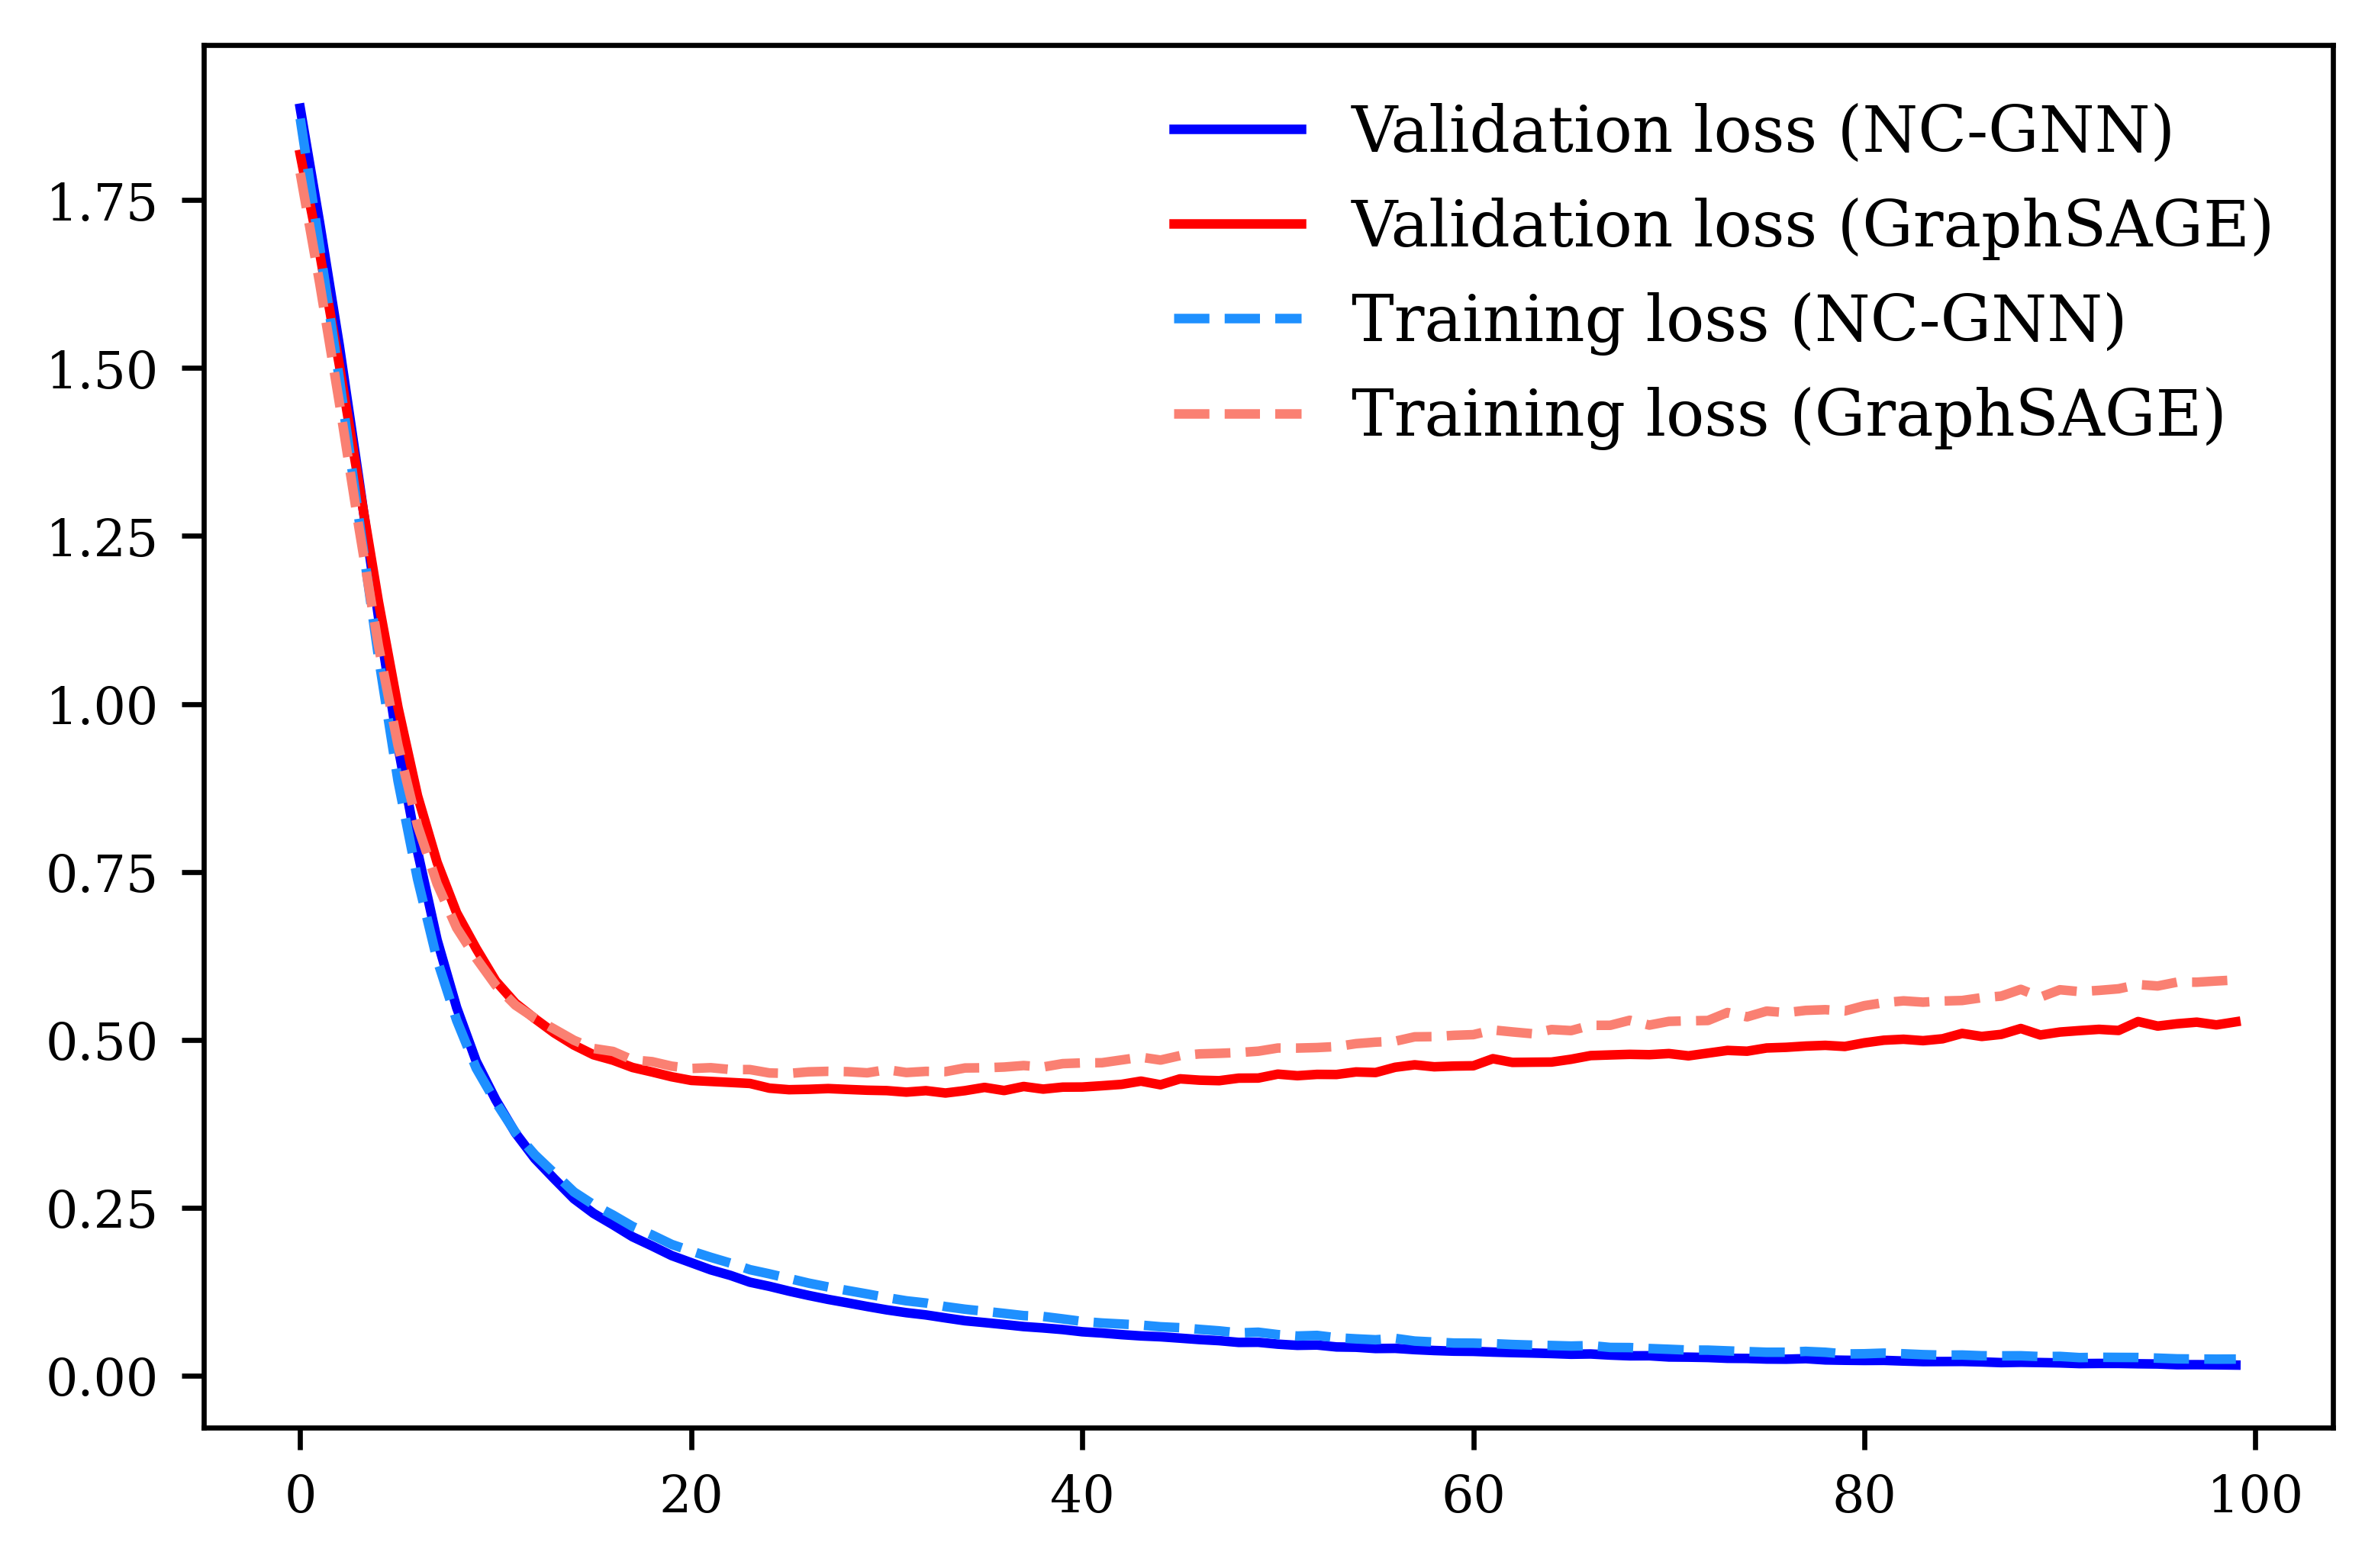

In [76]:
import matplotlib.pyplot as plt
with plt.style.context(['ieee']): 
    fig, ax = plt.subplots(figsize=(6,4))

    ax.plot(loss_ncgcn[0],'-',color='b',label='Validation loss (NC-GNN)')
    ax.plot(loss_ncgcn[1],'-',color='r',label='Validation loss (GraphSAGE)')
    ax.plot(loss_sage[0],'--',color='dodgerblue',label='Training loss (NC-GNN)')
    ax.plot(loss_sage[1],'--',color='salmon',label='Training loss (GraphSAGE)')
    ax.legend(fontsize=10,loc=1,frameon=False)

In [77]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/cora/loss.pkl',[loss_mlp,loss_sage,loss_ncgcn])

# r versus accuracy

In [21]:
training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,0)

In [22]:
    acc_lists = []    
    new_adjs = {}
    for key in full_adjs:
        neighbs_set = full_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
            
    #res = train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0,100,5,7,'./cora/',hidden=128,lr=0.0002,batch_size=128)   
    for j in range(20):
        acc_list = []
        for i in range(0,16):
            acc_list.append(train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0.1*i,100,5,7,'./cora/',hidden=128,lr=0.0002,batch_size=128)[2])
        acc_lists.append(acc_list)
        


In [23]:
acc_array = np.array(acc_lists)

In [8]:
np.mean(acc_array,axis=0)

array([0.86396484, 0.86689453, 0.86835938, 0.86972656, 0.87099609,
       0.87607422, 0.88085938, 0.88144531, 0.88330078, 0.88398438,
       0.88115234, 0.88076172, 0.87402344, 0.87119141, 0.86494141,
       0.85996094])

In [9]:
import matplotlib.pyplot as plt

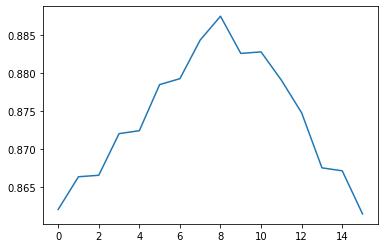

In [93]:
plt.plot(np.mean(acc_array,axis=0))

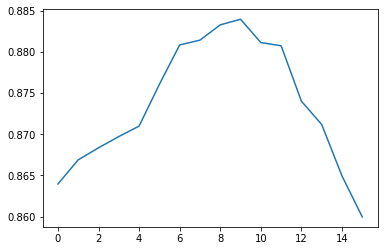

In [10]:
plt.plot(np.mean(acc_array,axis=0))

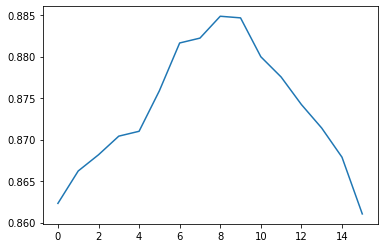

In [24]:
plt.plot(np.mean(acc_array,axis=0))

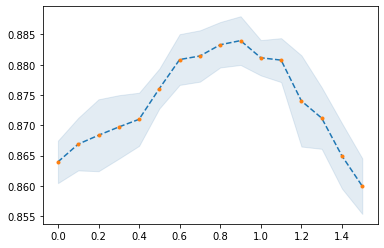

In [20]:
plt.plot([i*0.1 for i in range(16)],np.mean(acc_array,axis=0),'--')
plt.plot([i*0.1 for i in range(16)],np.mean(acc_array,axis=0),'.')
plt.fill_between([i*0.1 for i in range(16)],np.mean(acc_array,axis=0)-np.std(acc_array,axis=0),np.mean(acc_array,axis=0)+np.std(acc_array,axis=0),color='steelblue',alpha=0.15)


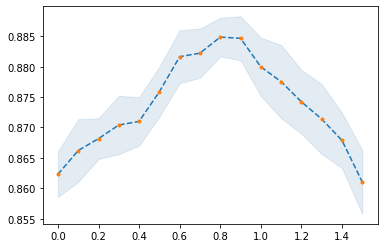

In [25]:
plt.plot([i*0.1 for i in range(16)],np.mean(acc_array,axis=0),'--')
plt.plot([i*0.1 for i in range(16)],np.mean(acc_array,axis=0),'.')
plt.fill_between([i*0.1 for i in range(16)],np.mean(acc_array,axis=0)-np.std(acc_array,axis=0),np.mean(acc_array,axis=0)+np.std(acc_array,axis=0),color='steelblue',alpha=0.15)


In [26]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/cora/acc_array_20.pkl',acc_array)

In [100]:
train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,8,100,5,7,'./cora/',hidden=128,lr=0.0002,batch_size=128)[2]

0.755859375

In [97]:
results_mlp[0][2]

0.751953125

In [35]:
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,1)
    acc_lists = []    
    new_adjs = {}
    for key in full_adjs:
        neighbs_set = full_adjs[key] | set([key])
        #neighbs_set = full_adjs[key] 
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        #neighbs_set = training_adjs[key]
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
           
    #res = train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0,100,5,7,'./cora/',hidden=128,lr=0.0002,batch_size=128)   
    for j in range(10):
        acc_list = []
        for i in range(0,5):
            acc_list.append(train_1(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,1*i,100,5,7,'./cora/',hidden=128,lr=0.0002,batch_size=128)[2])
        acc_lists.append(acc_list)
        



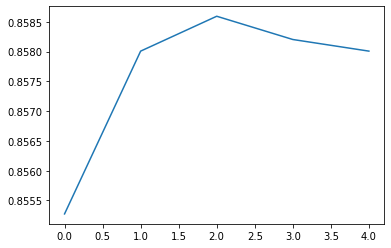

In [33]:
acc_array = np.array(acc_lists)
plt.plot(np.mean(acc_array,axis=0))

## concatenation


In [9]:
cancat_results_sagegcn_0_1 = []
cancat_results_sagegcn_0_2l = []
cancat_results_sagegcn_0_3l = []

for seed in range(10):
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,seed)
    
    new_adjs = {}
    for key in full_adjs:
        neighbs_set = full_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
    cancat_results_sagegcn_0_1.append(train_1(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0,500,5,7,'./cora/',hidden=128,lr=0.0002,batch_size=128))        
    cancat_results_sagegcn_0_2l.append(train_2l(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0,500,5,7,'./cora/',hidden=128,lr=0.0002,batch_size=128))
    cancat_results_sagegcn_0_3l.append(train_3l(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0,500,5,7,'./cora/',hidden=128,lr=0.0002,batch_size=128))



In [12]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/cora/concat/sage_0_1.pkl',cancat_results_sagegcn_0_1)
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/cora/concat/sage_0_2l.pkl',cancat_results_sagegcn_0_2l)
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/cora/concat/sage_0_3l.pkl',cancat_results_sagegcn_0_3l)

In [4]:
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,1)
    
    new_adjs = {}
    for key in full_adjs:
        neighbs_set = full_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))

In [38]:

%time train_2l(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0.05,500,5,7,'./cora/',hidden=128,lr=0.0002,batch_size=128)[2]


CPU times: user 3min 12s, sys: 3.14 s, total: 3min 15s
Wall time: 16.3 s


0.892578125

In [39]:
%time train_2l(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0.1,500,5,7,'./cora/',hidden=128,lr=0.0002,batch_size=128)[2]


CPU times: user 2min 45s, sys: 2.49 s, total: 2min 47s
Wall time: 14 s


0.880859375

In [40]:
a = []
for i in cancat_results_sagegcn_0_1:
    a.append(i[2])
sum(a)

NameError: name 'cancat_results_sagegcn_0_1' is not defined

In [14]:
a = []
for i in cancat_results_sagegcn_0_2l:
    a.append(i[2])
sum(a)

8.740234375

In [15]:
a=[]
for i in cancat_results_sagegcn_0_3l:
    a.append(i[2])
sum(a)

8.73828125

In [88]:
cancat_results_sagegcn_best_1 = []
cancat_results_sagegcn_best_2l = []
cancat_results_sagegcn_best_3l = []
for seed in range(10):
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,seed)
    
    new_adjs = {}
    for key in full_adjs:
        neighbs_set = full_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
            
    res = train_1(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0,500,5,7,'./cora/',hidden=128,lr=0.0002,batch_size=128)   
    for i in range(1,11):
        temp = train_1(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0.2*i,500,5,7,'./cora/',hidden=128,lr=0.0002,batch_size=128)
        if res[2] < temp[2]:
            res = temp 
    cancat_results_sagegcn_best_1.append(res)
    
    res = train_2l(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0,500,5,7,'./cora/',hidden=128,lr=0.0002,batch_size=128)   
    for i in range(1,11):
        temp = train_2l(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0.2*i,500,5,7,'./cora/',hidden=128,lr=0.0002,batch_size=128)
        if res[2] < temp[2]:
            res = temp 
    cancat_results_sagegcn_best_2l.append(res)
    
    res = train_3l(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0,500,5,7,'./cora/',hidden=128,lr=0.0002,batch_size=128)   
    for i in range(1,11):
        temp = train_3l(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0.2*i,500,5,7,'./cora/',hidden=128,lr=0.0002,batch_size=128)
        if res[2] < temp[2]:
            res = temp 
    cancat_results_sagegcn_best_3l.append(res)


In [105]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/cora/concat/sage_best_1.pkl',cancat_results_sagegcn_best_1)
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/cora/concat/sage_best_2l.pkl',cancat_results_sagegcn_best_2l)
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/cora/concat/sage_best_3l.pkl',cancat_results_sagegcn_best_3l)

In [98]:
a = []
for i in cancat_results_sagegcn_best_1:
    a.append(i[2])
sum(a)

8.703125

In [99]:
a = []
for i in cancat_results_sagegcn_best_2l:
    a.append(i[2])
sum(a)

8.80859375

In [100]:
a = []
for i in cancat_results_sagegcn_best_3l:
    a.append(i[2])
sum(a)

8.841796875

# feature dimension reduction

In [136]:
from sklearn.decomposition import PCA

In [138]:
pca = PCA(n_components=700)

In [139]:
feat_data_compress_700 = pca.fit_transform(feat_data)

In [143]:

results_mlp_700 = []
    
for seed in range(2):
    import torch
    from torch import nn
    from torch.nn import ReLU
    
    from torch.autograd import Variable
    from sklearn.metrics import f1_score,accuracy_score
    import glob
    import os
    import time
    batch_size = 128
    t_total = time.time()
    loss_values = []
    loss_train = []
    bad_counter = 0
    epochs = 70
    best = epochs + 1
    best_epoch = 0   
    temp_path = './cora/'
    patience = 5
    num_class = 7
    hidden_num = 128
    lr = 0.0002
    #results = []
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,seed)
    class MLPModel(nn.Module):
        def __init__(self,num_classes,hidden_dim,feature_dim):
            super(MLPModel,self).__init__()
            self.hidden = nn.Linear(feature_dim,hidden_dim)
            self.layer = nn.Linear(hidden_dim,num_classes)
            self.xent = nn.CrossEntropyLoss()
            self.act1 = ReLU()
        def forward(self,nodes):
            X = self.hidden(nodes)
            X = self.act1(X)
            scores = self.layer(X)
            return scores
        def loss(self,nodes,labels):
            scores = self.forward(nodes)
            return self.xent(scores,labels.squeeze())
        
    mlp = MLPModel(num_class,hidden_num,feat_data_compress_700.shape[1] )
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, mlp.parameters()), lr=lr)
    
    
    for epoch in range(epochs):
        random.shuffle(training)
        num_batches = int(len(training) / batch_size) + 1
        train_losses = []
        start_time = time.time()
        for batch in range(num_batches):   
            i_start = batch * batch_size
            i_end = min((batch + 1) * batch_size, len(training))
            batch_nodes = training[i_start:i_end]
            
            optimizer.zero_grad()
            loss = mlp.loss(Variable(torch.Tensor(feat_data_compress_700[np.array(batch_nodes)])),Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
            
            train_losses.append(loss.data.item())
            loss.backward()
            optimizer.step()
    
        
        num_batches_valid = int(len(validation) / batch_size) 
        valid_losses = []
        for batch in range(num_batches_valid):
            i_start = batch * batch_size
            i_end = min((batch + 1) * batch_size, len(validation))
            batch_nodes = validation[i_start:i_end]
    
            loss = mlp.loss(Variable(torch.Tensor(feat_data_compress_700[np.array(batch_nodes)])),Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
            
            valid_losses.append(loss.data.item())
  
        
        loss_train.append(np.average(train_losses))
        loss_values.append(np.average(valid_losses))
        torch.save(mlp.state_dict(),temp_path+'{}.pkl'.format(epoch))
        if loss_values[-1] < best:
            best = loss_values[-1]
            best_epoch = epoch 
            bad_counter = 0
        else:
            bad_counter += 1
        if bad_counter == patience:
            break
        files = glob.glob(temp_path+'*.pkl')
        for file in files:
            epoch_nb = int(file[len(temp_path):].split('.')[0])
            if epoch_nb < best_epoch:
                os.remove(file)
    files = glob.glob(temp_path+'*.pkl')
    for file in files:
        epoch_nb = int(file[len(temp_path):].split('.')[0])
        if epoch_nb > best_epoch:
            os.remove(file)

    mlp.load_state_dict(torch.load(temp_path+'{}.pkl'.format(best_epoch)))        
    print(best_epoch)
    
    num_batches_test = int(len(testing) / batch_size) 
    test_outputs = []
    test_labels = []
    for batch in range(num_batches_test):
        i_start = batch * batch_size
        i_end = (batch + 1) * batch_size
        batch_nodes = testing[i_start:i_end]
        test_output = torch.zeros(batch_size,num_class)
        for i in range(3):
            test_output = test_output + mlp.forward(torch.Tensor(feat_data_compress_700[np.array(batch_nodes)]))
        test_outputs.extend(list(test_output.data.cpu().numpy().argmax(axis=1)))
        test_labels.extend(list(labels[batch_nodes]))
        
    results_mlp_700.append([loss_train,loss_values,accuracy_score(test_labels,test_outputs)])

69
69


In [145]:
for i in results_mlp_700:
    print(i[2])

0.73828125
0.736328125


In [146]:
for i in results_mlp:
    print(i[2])

0.751953125
0.75
0.7578125
0.7734375
0.794921875
0.767578125
0.771484375
0.76953125
0.76953125
0.7578125


In [149]:
#results_sagegcn_0 = []
for seed in range(2):
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,seed)
    
    new_adjs = {}
    for key in full_adjs:
        neighbs_set = full_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
    
    results_sagegcn_0.append(train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0,100,5,7,'./cora/',hidden=128,lr=0.0002,batch_size=128)
)



In [150]:
for i in results_sagegcn_0:
    print(i[2])

0.8671875
0.859375
0.865234375
0.87109375


In [4]:
#results_sagegcn_best = []
for seed in range(2):
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,seed)
    
    new_adjs = {}
    for key in full_adjs:
        neighbs_set = full_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
            
    res = train_1(False,True,feat_data_compress_700,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0.8,100,5,7,'./cora/',hidden=128,lr=0.0002,batch_size=128)   
    #for i in range(1,7):
    #    temp = train_1(False,True,feat_data_compress_700,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0.2*i,100,5,7,'./cora/',hidden=128,lr=0.0002,batch_size=128)
    #    if res[2] < temp[2]:
    #        res = temp 
    
    results_sagegcn_best.append(res)





NameError: name 'feat_data_compress_700' is not defined

In [157]:
for i in results_sagegcn_best:
    print(i[2])

0.884765625
0.875
0.87890625
0.873046875


# structure analysis

In [5]:
import networkx as nx

In [6]:
def shuffle_edges(dict_edges,n_swap,n_try):
    G_ = nx.Graph(dict_edges)
    G_swap = nx.double_edge_swap(G_,n_swap,n_try)
    edge_list = list(nx.to_edgelist(G_swap))
    adj_lists = defaultdict(set)
    for i in range(len(a)):
        adj_lists[edge_list[i][0]].add(edge_list[i][1])
        adj_lists[edge_list[i][1]].add(edge_list[i][0])    
    return adj_lists

In [8]:
com = []
for key in full_adjs:
    for i in full_adjs[key]:
        if labels[key][0] == labels[i][0]:
            com.append([key,i])

In [10]:
G_ = nx.Graph(full_adjs)

In [12]:
G_.number_of_edges()

5278

In [13]:
G_.number_of_nodes()

2708

In [20]:
ego_nodes = [i for i in range(20)]

In [22]:
egos = [nx.ego_graph(G_,node) for node in ego_nodes]

In [15]:
from operator import itemgetter
node_and_degree = G_.degree()
(largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]

In [19]:
nx.info(G_,3)

'Node 3 has the following properties:\nDegree: 3\nNeighbors: 601 463 197'

In [24]:
G_ego = G_.__class__()

In [25]:
G_ego

In [31]:
for ego in egos:
    G_ego.add_nodes_from(ego.nodes)
    G_ego.add_edges_from(ego.edges)

In [40]:
dict(G_ego.degree([i for i in range(20)]))

{0: 5,
 1: 1,
 2: 4,
 3: 3,
 4: 1,
 5: 2,
 6: 2,
 7: 1,
 8: 5,
 9: 4,
 10: 5,
 11: 2,
 12: 2,
 13: 3,
 14: 19,
 15: 10,
 16: 4,
 17: 1,
 18: 7,
 19: 2}

In [39]:
num_e = {}
for i in range(len(egos)):
    num_e[i] = egos[i].degree(i)
num_e

{0: 5,
 1: 1,
 2: 4,
 3: 3,
 4: 1,
 5: 2,
 6: 2,
 7: 1,
 8: 5,
 9: 4,
 10: 5,
 11: 2,
 12: 2,
 13: 3,
 14: 19,
 15: 10,
 16: 4,
 17: 1,
 18: 7,
 19: 2}

In [41]:
dict(G_ego.degree([i for i in range(20)])) == num_e

True